In [92]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [199]:
train_ind = pd.read_csv('/Users/jackconnors/Downloads/ind_train.csv')
train_dep = pd.read_csv('/Users/jackconnors/Downloads/dep_train.csv')
test_ind = pd.read_csv('/Users/jackconnors/Downloads/test_set_ind.csv')

In [100]:
train_dep.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [101]:
merge_train = pd.merge(train_ind, train_dep, on="id")

# Clean Data

In [109]:
merge_train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

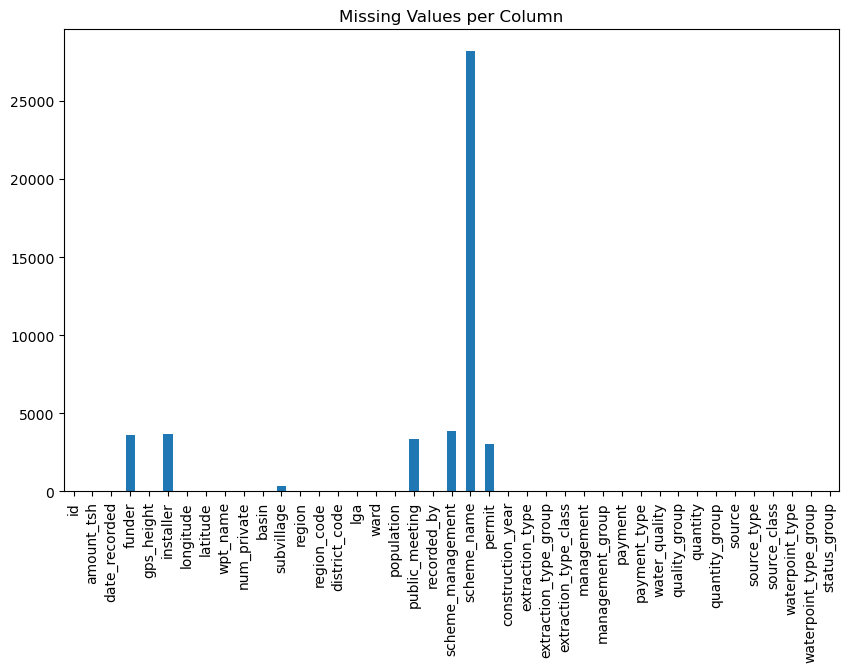

In [148]:
plt.figure(figsize=(10, 6))
missing_values = merge_train.isnull().sum()
missing_values.plot(kind='bar')
plt.title("Missing Values per Column")
plt.xticks(rotation=90)
plt.show()

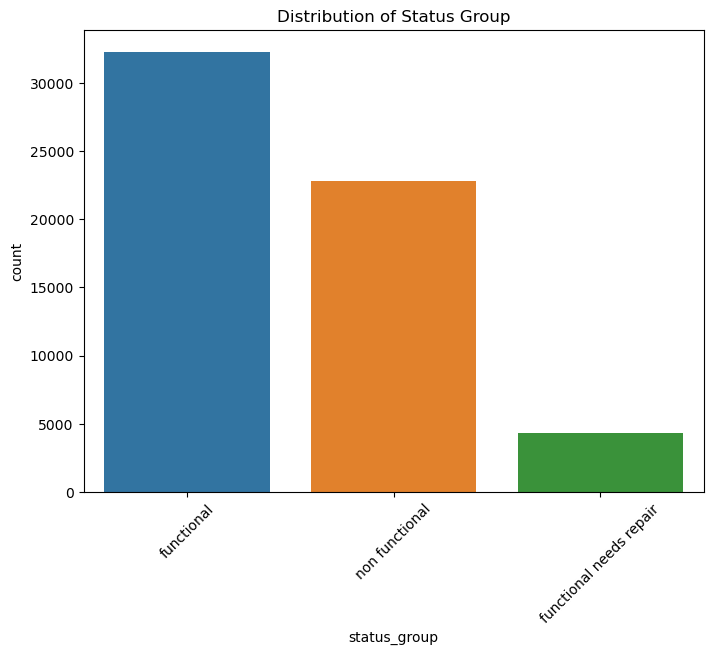

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(data=merge_train, x='status_group')
plt.title("Distribution of Status Group")
plt.xticks(rotation=45)
plt.show()

/var/folders/78/lyg5vs3x05n9nf7j9ttzb0yc0000gn/T/ipykernel_10494/772260158.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = selected_columns.corr()


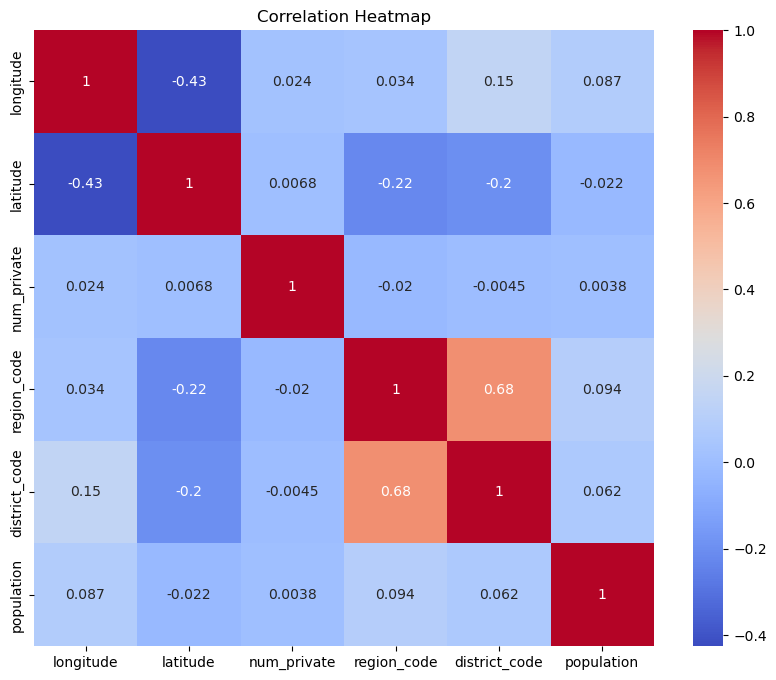

In [147]:
selected_columns = merge_train.iloc[:, 6:20]


plt.figure(figsize=(10, 8))
correlation_matrix = selected_columns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

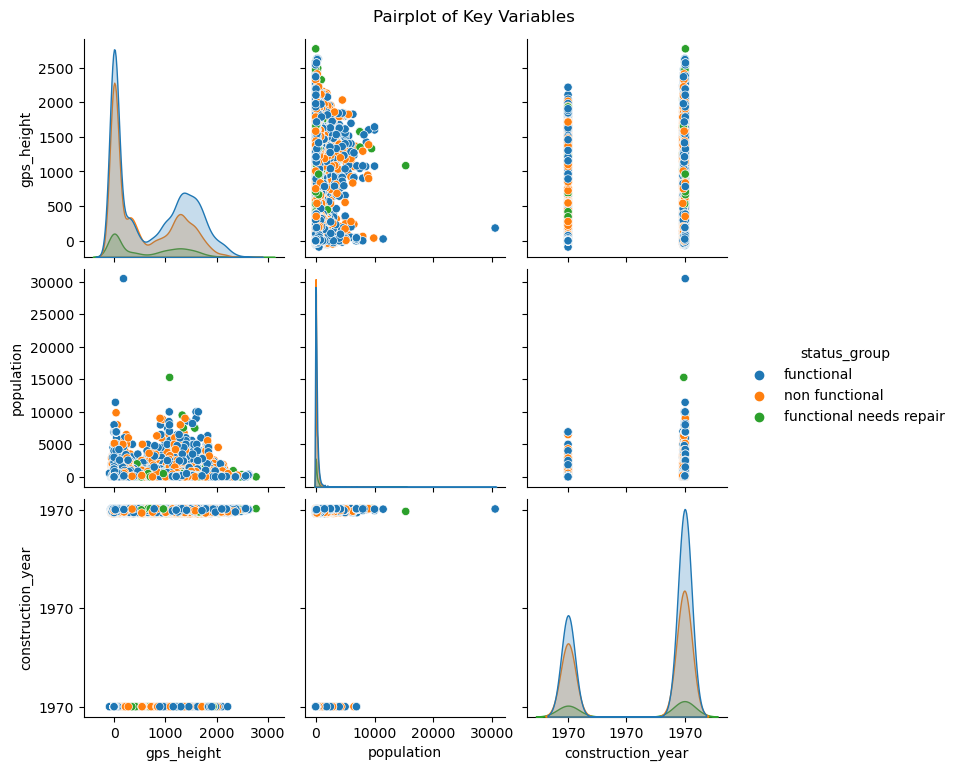

In [227]:
sns.pairplot(data=merge_train, vars=['gps_height', 'population', 'construction_year'], hue='status_group')
plt.suptitle("Pairplot of Key Variables", y=1.02)
plt.show()

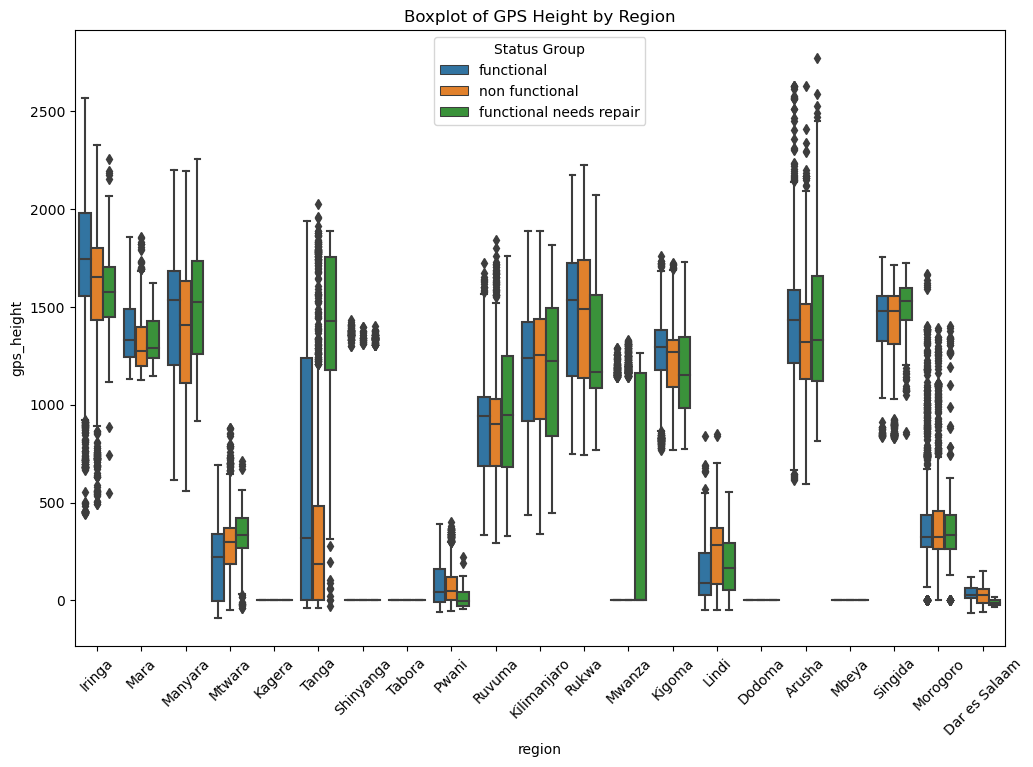

In [155]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=merge_train, x='region', y='gps_height', hue='status_group')
plt.title("Boxplot of GPS Height by Region")
plt.xticks(rotation=45)
plt.legend(title='Status Group')
plt.show()

# Convert Date to Date Type and Create Duration Variable

In [156]:
merge_train['date_recorded'] = pd.to_datetime(merge_train['date_recorded'])
merge_train['construction_year'] = pd.to_datetime(merge_train['construction_year'])

In [157]:
merge_train['duration'] = merge_train['date_recorded'] - merge_train['construction_year']

In [158]:
resp_vars = merge_train[['duration', 'water_quality', 'management', 'id', 'status_group']]

In [159]:
resp_vars.head()

,duration,water_quality,management,id,status_group
0,15046 days 23:59:59.999998001,soft,vwc,69572,functional
1,15769 days 23:59:59.999997990,soft,wug,8776,functional
2,15760 days 23:59:59.999997991,soft,vwc,34310,functional
3,15732 days 23:59:59.999998014,soft,vwc,67743,non functional
4,15168 days 00:00:00,soft,other,19728,functional


# Classification Model

In [160]:
resp_vars.isna().sum()

duration         0
water_quality    0
management       0
id               0
status_group     0
dtype: int64

# Classification Model

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [162]:
x = resp_vars[['duration', 'water_quality', 'management']]
y= resp_vars[['status_group']]

In [163]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.values.ravel())

In [175]:
# Create a copy of the DataFrame
x_copy = x.copy()

In [176]:
# Convert 'duration' to seconds in the copied DataFrame
x_copy['duration_seconds'] = x_copy['duration'].dt.total_seconds()
x_copy = x_copy.drop('duration', axis=1)


In [177]:
# Create an instance of OneHotEncoder
encoder = OneHotEncoder()

In [178]:
categorical_columns = ['water_quality', 'management']
encoded_features = encoder.fit_transform(x_copy[categorical_columns])

In [179]:
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

In [183]:
# Concatenate the encoded DataFrame with x_copy
x = x.assign(duration_seconds=x_copy['duration_seconds'])

In [184]:
# Assign the modified values back to the original DataFrame using .loc
x.loc[x.index, 'duration_seconds'] = x_copy['duration_seconds']

In [185]:
x = x.drop('duration', axis=1)

In [186]:
clf = RandomForestClassifier()

In [195]:
y.head()

,status_group
0,functional
1,functional
2,functional
3,non functional
4,functional


In [193]:
clf.fit(x_encoded, y)

/var/folders/78/lyg5vs3x05n9nf7j9ttzb0yc0000gn/T/ipykernel_10494/798691402.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_encoded, y)


RandomForestClassifier()

In [194]:
print(clf.feature_importances_)

[7.19026950e-01 3.80759766e-03 3.70940846e-03 5.21945704e-04
 3.49843657e-03 1.34858532e-02 4.99890850e-03 3.52977714e-02
 7.68123018e-02 1.15263005e-02 3.06766416e-03 3.92904929e-03
 3.98377008e-03 1.41738062e-02 8.71623755e-04 5.23165479e-03
 4.07630632e-02 6.44170959e-03 2.55999711e-02 1.08283918e-02
 1.24238222e-02]


# Make Prediction

In [205]:
test_ind['date_recorded'] = pd.to_datetime(test_ind['date_recorded'])
test_ind['construction_year'] = pd.to_datetime(test_ind['construction_year'])

In [206]:
test_ind['duration'] = test_ind['date_recorded'] - test_ind['construction_year']

In [201]:
test_ind.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2/4/13,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2/4/13,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2/1/13,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,1/22/13,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,3/27/13,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [207]:
test_vars = test_ind[['gps_height', 'water_quality', 'funder']]

In [208]:
test_vars.head()

,duration,water_quality,funder
0,15739 days 23:59:59.999997988,soft,Dmdd
1,15739 days 23:59:59.999998,soft,Government Of Tanzania
2,15736 days 23:59:59.999997990,soft,NaN
3,15726 days 23:59:59.999998013,soft,Finn Water
4,15790 days 23:59:59.999998,soft,Bruder


In [209]:
test_vars = test_vars.drop('duration', axis=1)

In [ ]:
test_vars_encoded = pd.concat([test_vars.drop(categorical_columns, axis=1), encoded_test_df], axis=1)

In [133]:
predictions

array([0, 0, 0, ..., 2, 0, 0])

In [ ]:
predictions = clf.predict(test_vars_encoded)

In [137]:
predictions_submit = label_encoder.inverse_transform(predictions)

In [138]:
predictions_submit

array(['functional', 'functional', 'functional', ..., 'non functional',
       'functional', 'functional'], dtype=object)

In [139]:
submission_df = pd.DataFrame(predictions_submit, columns=['status_group'])

In [140]:
submission_df.to_csv('submission.csv', index=False)

In [ ]:
#### Logit ####

In [211]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [220]:
# Preprocess the data
label_encoder = LabelEncoder()

In [ ]:
resp_vars.loc[:, 'water_quality'] = label_encoder.fit_transform(resp_vars.loc[:, 'water_quality'])

In [ ]:
resp_vars['management'] = label_encoder_py.fit_transform(resp_vars['management'])

In [ ]:
 Convert 'duration' to numeric
resp_vars['duration'] = resp_vars['duration'].dt.days

In [ ]:
# Define features and target
X = resp_vars[['duration', 'water_quality', 'management']]
y = resp_vars['status_group']

In [ ]:
# Encoding target variable y
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Initialize the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)

In [ ]:
# Train the model
clf.fit(X_train, y_train)

In [ ]:
# Predict on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")